In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

# Paths
SKETCHES_FOLDER = 'dataset_quickdraw/sketches/sketches'
IMAGE_SIZE = 28

# List and select 10 class files
all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])
selected_npz_files = all_npz_files[:10]
print("Selected classes:", selected_npz_files)

# Label map: filename (e.g., 'apple.npz') -> label index
label_map = {fname: idx for idx, fname in enumerate(selected_npz_files)}

# Sketch-to-image function (same as yours)
def sketch_to_image(sketch, image_size=28, padding=2):
    x, y = 0, 0
    abs_coords = []
    for dx, dy, pen in sketch:
        x += dx
        y += dy
        abs_coords.append((x, y, pen))
    
    strokes = []
    current_stroke = []
    for x, y, pen in abs_coords:
        if pen == 0:
            current_stroke.append((x, y))
        elif pen == 1:
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
        elif pen == 2:
            break
    if current_stroke:
        strokes.append(current_stroke)
    
    all_points = [pt for stroke in strokes for pt in stroke]
    if not all_points:  # Handle empty drawings
        return np.ones((image_size, image_size), dtype=np.float32)
    
    xs, ys = zip(*all_points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    scale = (image_size - 2 * padding) / max(max_x - min_x, max_y - min_y + 1e-5)
    
    img = Image.new('L', (image_size, image_size), 'white')
    draw = ImageDraw.Draw(img)
    for stroke in strokes:
        scaled = [((x - min_x) * scale + padding, (y - min_y) * scale + padding) for x, y in stroke]
        draw.line(scaled, fill=0, width=1)
    
    return np.array(img, dtype=np.float32) / 255.0

# Initialize lists
X = []
y = []

# Load and process data
for class_file in selected_npz_files:
    label = label_map[class_file]
    data_path = os.path.join(SKETCHES_FOLDER, class_file)
    data = np.load(data_path, allow_pickle=True, encoding='latin1')
    
    train_strokes = data['train']
    print(f"Loaded {len(train_strokes)} samples for class {class_file.replace('.npz', '')}")
    
    for sketch in train_strokes:
        img = sketch_to_image(sketch)
        X.append(img)
        y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension (1 channel grayscale)
X = X.reshape((-1, 28, 28, 1))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Summary
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


Selected classes: ['The Eiffel Tower.npz', 'The Great Wall of China.npz', 'The Mona Lisa.npz', 'aircraft carrier.npz', 'airplane.npz', 'alarm clock.npz', 'ambulance.npz', 'angel.npz', 'animal migration.npz', 'ant.npz']
Loaded 70000 samples for class The Eiffel Tower
Loaded 70000 samples for class The Great Wall of China
Loaded 70000 samples for class The Mona Lisa
Loaded 70000 samples for class aircraft carrier
Loaded 70000 samples for class airplane
Loaded 70000 samples for class alarm clock
Loaded 70000 samples for class ambulance
Loaded 70000 samples for class angel
Loaded 70000 samples for class animal migration
Loaded 70000 samples for class ant
Total samples: 700000
Training samples: 560000
Validation samples: 140000
X_train shape: (560000, 28, 28, 1), y_train shape: (560000,)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Dropout, Flatten, Dense)

def build_sketch_model(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Classification Head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [3]:
model = build_sketch_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\Umer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,442 (947.04 KB)

 Trainable params: 241,994 (945.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64
)


Epoch 1/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 1154s 131ms/step - accuracy: 0.8307 - loss: 0.5476 - val_accuracy: 0.8887 - val_loss: 0.3544
Epoch 2/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 1062s 121ms/step - accuracy: 0.8841 - loss: 0.3828 - val_accuracy: 0.9039 - val_loss: 0.3024
Epoch 3/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 875s 100ms/step - accuracy: 0.8940 - loss: 0.3467 - val_accuracy: 0.8986 - val_loss: 0.3192
Epoch 4/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 918s 99ms/step - accuracy: 0.8997 - loss: 0.3276 - val_accuracy: 0.9101 - val_loss: 0.2860
Epoch 5/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 22766s 3s/step - accuracy: 0.9029 - loss: 0.3137 - val_accuracy: 0.9115 - val_loss: 0.2826
Epoch 6/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 973s 111ms/step - accuracy: 0.9056 - loss: 0.3051 - val_accuracy: 0.9141 - val_loss: 0.2772
Epoch 7/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 884s 101ms/step - accuracy: 0.9071 - loss: 0.2980 - val_accuracy: 0.9126 - val_loss: 0.2761
Epoch 8/15
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 28248s 3s/step - acc

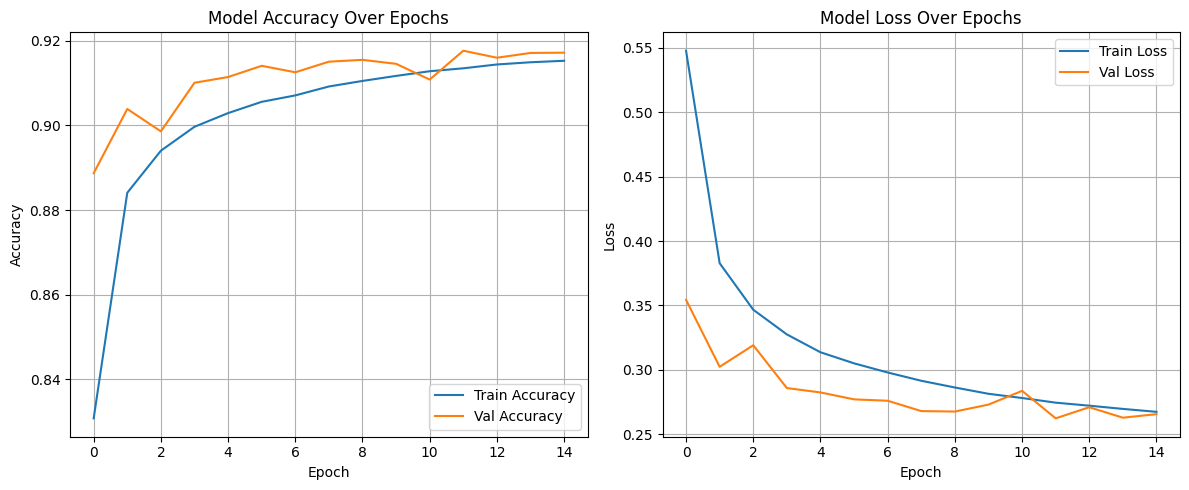

In [5]:
import matplotlib.pyplot as plt

def plot_training_history(history): #plot loss and accuracy
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


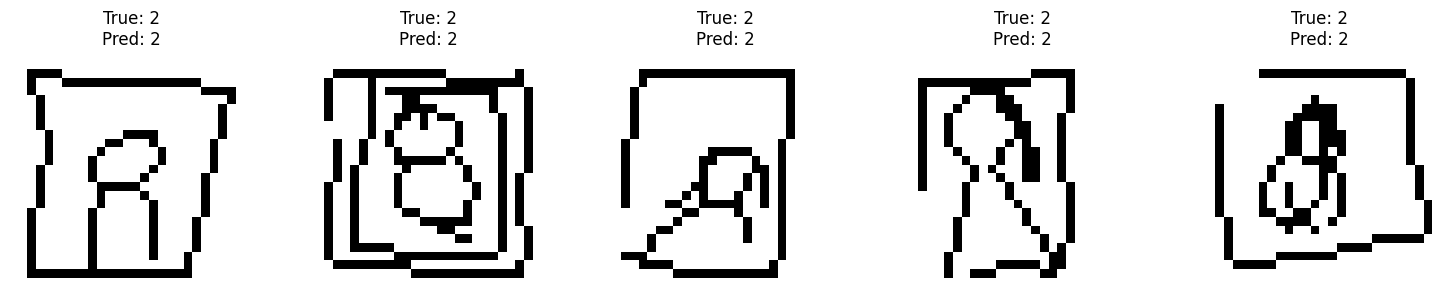

In [ ]:
# Load some unseen sketches from another split (e.g., 'test')
import random

def test_unseen_sketch(model, class_file, label, num_samples=5):
    test_data = np.load(os.path.join(SKETCHES_FOLDER, class_file), allow_pickle=True, encoding='latin1')
    sketches = test_data['test']
    
    indices = random.sample(range(len(sketches)), num_samples)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        sketch = sketches[idx]
        img = sketch_to_image(sketch).reshape(1, 28, 28, 1)
        
        prediction = model.predict(img)
        pred_label = np.argmax(prediction)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage: Test on the 3rd class in your list that is the mona lisa
class_index = 2
test_unseen_sketch(model, selected_npz_files[class_index], label=class_index, num_samples=5)


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step


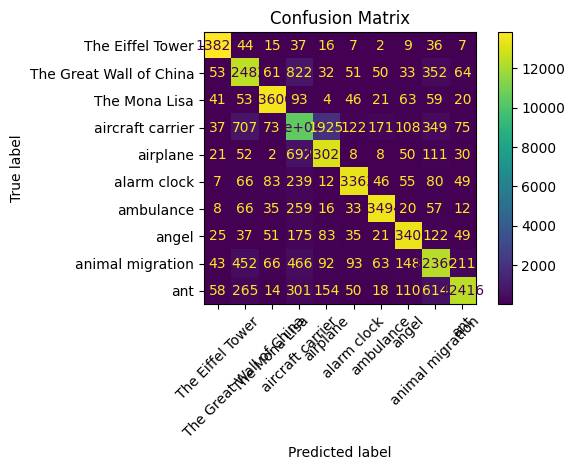

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the entire validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f.replace('.npz','') for f in selected_npz_files])
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
